# Silicon: density of states of the valance band

The valance band can be described using two parabolas. One for heavy holes and one for light holes.
The dispersion relation for those bands are listed below:

$\begin{equation}
E_{v,lh}=-\frac{\hbar^2}{2m_{e}}\left(4.1k^2-\sqrt{1.21k^4+4.1(k_x^2k_y^2+k_x^2k_z^2+k_y^2k_z^2)}\right)
\end{equation}$

$\begin{equation}
E_{v,hh}=-\frac{\hbar^2}{2m_{e}}\left(4.1k^2+\sqrt{1.21k^4+4.1(k_x^2k_y^2+k_x^2k_z^2+k_y^2k_z^2)}\right),
\end{equation}$

One can notice that the dispersion relation is symmetric in x, y, z. This allows to calculate only 1/8 of the k space(positive k values)

By calculating the energy on a cubic grid we can determine the Density of states by counting the energies. This is done by binning using the numpy.histogram method.

Because we calculate only 1/8 of the k space and our k-point spacing is different the density of states has to be calculated with a constant.

In [1]:
#initializing python libraries
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Calculate D(E) for light + heavy holes
The calculation takes the positive octant of k-space and calculates the corresponding energies. This is done in sets of 1000000 points, which are binned(600 bins between 0 and -0.06eV) to save memory. In total $1000^3$ points are calculated.

In [2]:
from scipy.constants import hbar, m_e, eV, angstrom
import itertools as it

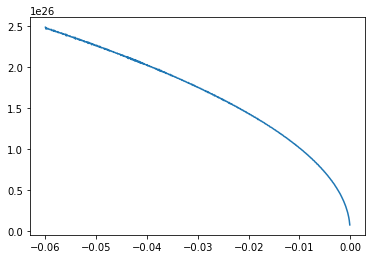

In [35]:
from numba import jit

kmax = pi/(angstrom*5.43)/4
kmax2 = kmax**2
nofkpoints = 1000
krange = linspace(0,kmax,nofkpoints)**2
it_k = it.product(krange,krange,krange)
bins = linspace(-0.06,0,600)
freq = zeros(bins.size-1)
done=False
count = 0;

@jit
def get_k(kx,ky,kz):
    return kx+ky+kz

@jit
def root_part(k,kx,ky,kz):
    return sqrt(1.21*k**2+4.1*(kx*ky+kx*kz+ky+kz)) 

@jit
def get_heavy(part1,part2):
    return -1/eV*hbar**2/(2*m_e)*(4.1*part1+part2)
    
@jit
def get_light(part1,part2):
    return -1/eV*hbar**2/(2*m_e)*(4.1*part1-part2)

@jit
def get_freq_hist(x,bins):
    freq,_ = histogram(x,bins=bins)
    return freq

@jit
def get_freq_for_n(it_k,n):
    energy = empty([n,2])
    count = 0
    for i,(kx,ky,kz) in enumerate(it_k):
        k = get_k(kx,ky,kz)
        energy[i,0] = k 
        energy[i,1] = root_part(k,kx,ky,kz)
        count = i
        if i >= n-1:
            break;            
    heavy = get_heavy(energy[:,0],energy[:,1])
    light = get_light(energy[:,0],energy[:,1])
    freq = zeros(bins.size-1)
    if count == n:
        h_freq = get_freq_hist(heavy,bins)
        l_freq = get_freq_hist(light,bins)
    else:
        h_freq = get_freq_hist(heavy[~isnan(heavy)],bins)
        l_freq = get_freq_hist(light[~isnan(light)],bins)
    freq =  h_freq + l_freq
    return freq

while(nofkpoints**3 > count):
    n = 1000000
    nfreq = get_freq_for_n(it_k,n)
    freq = freq+nfreq    
    count = count + n
    print(count/nofkpoints**3,end="\r")
figure()

dE = bins[1]-bins[0]
L = 2*pi / (sqrt(krange[1])-sqrt(krange[0]))
freq = 8 * freq / dE / L**3
plot(bins[:-1],freq)

In [37]:
import pandas as pd

In [49]:
df = pd.DataFrame(data = {"freq":freq,"bins":bins[:-1]})
df.head()
df.to_csv

,bins,freq
0,-0.060000,2.483979e+26
1,-0.059900,2.462724e+26
2,-0.059800,2.479219e+26
3,-0.059699,2.464649e+26
4,-0.059599,2.464522e+26
